# 0.0. IMPORTS

In [ ]:
import pandas as pd
import inflection
import math
import numpy as np 
import datetime
import seaborn as sns 

from matplotlib import pyplot as plt 
from IPython.core.display import HTML
from IPython.display import Image

## 0.1. Helper Functions

## 0.2. Loading data

In [ ]:
#load
df_sales_raw = pd.read_csv('train.csv' , low_memory=False)
df_store_raw = pd.read_csv('store.csv' , low_memory=False)

#merge
df_raw = pd.merge( df_sales_raw , df_store_raw, how='left' , on='Store' )

# 1.0. DESCRICAO DOS DADOS

In [ ]:
df1 = df_raw.copy()
df1.columns

## 1.1. Rename Columns

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

df1.columns

## 1.2. Data dimensions


In [ ]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Columns: {}'.format(df1.shape[1]))

## 1.3. Data types

In [ ]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

## 1.4. Check NA

In [ ]:
df1.isna().sum()

## 1.5. Fillout NA

In [ ]:
#competition_distance
df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan (x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6. Change Types

In [ ]:
#competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

#promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical 

In [ ]:
num_attributes = df1.select_dtypes ( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes ( exclude = ['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical attributes

In [ ]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply (np.std)).T
d2 = pd.DataFrame(num_attributes.apply (min)).T
d3 = pd.DataFrame(num_attributes.apply (max)).T
d4 = pd.DataFrame(num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply (lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply (lambda x: x.kurtosis())).T

#concatenate
m = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = ['attributes', 'min', 'max','range','mean', 'median', 'std','skew','kurtosis']

In [ ]:
m

In [ ]:
sns.distplot (df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply (lambda x: x.unique().shape[0])

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1 ,3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1 ,3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1 ,3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0. FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.0.1 Mapa mental de hipótesis

In [ ]:
Image('img/MindMapHypothesis.png')

## 2.1 Criacao das hipoteses

### 2.1.1 Hipoteses loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 Hipoteses produto


**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipoteses temporal

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [ ]:
#year
df2['year'] = df2['date'].dt.year 

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

#promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime
                                              .strptime( x + '-1', '%Y-%W-%w')
                                              - datetime.timedelta (days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply (lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday 
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [ ]:
df2.head().T

# 3.0. Filtragem de variaveis

In [ ]:
df3 = df2.copy()
df3.head()

## 3.1. Filtragem das linhas

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das colunas

In [ ]:
cols_drop = ['customers' , 'open' , 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. Analise Exploratoria dos Dados (EDA)

In [ ]:
df4 = df3.copy()

## 4.1. Analise univariada

### 4.1.1 Response variable

In [ ]:
sns.distplot( df4['sales'])

### 4.1.2 Numerical variable

In [ ]:
num_attributes.hist( bins=25);

### 4.1.3 Categorical variable

In [ ]:
df4['state_holiday'].drop_duplicates()

In [ ]:
#state_holiday
plt.subplot(3 , 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( data=a,x='state_holiday')

plt.subplot(3 , 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',fill=True)

#store_type
plt.subplot(3 , 2, 3)
sns.countplot( data=a,x='store_type')

plt.subplot(3 , 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b',fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d',fill=True)
#assortment
plt.subplot(3 , 2, 5)
sns.countplot( data=a,x='assortment')

plt.subplot(3 , 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',fill=True)

## 4.2. Analise bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**Falso.** Vende menos [assumindo extra como maior]



<Axes: xlabel='year_week'>

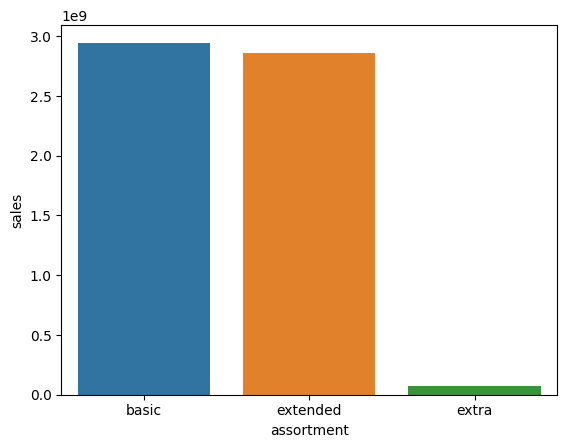

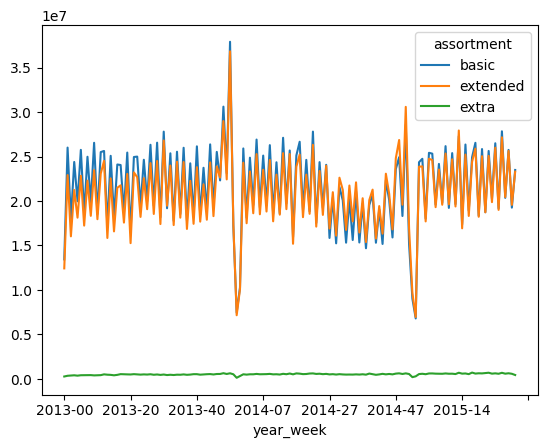

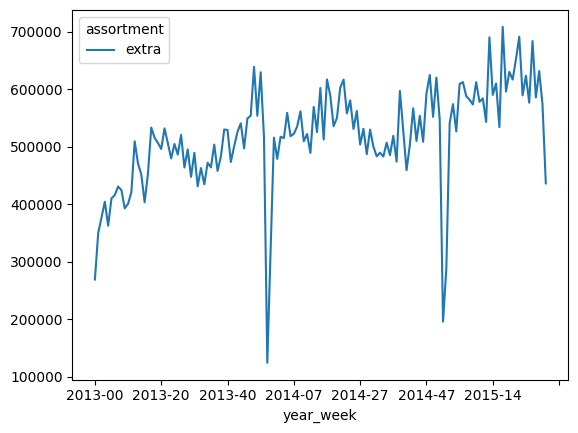

In [47]:
aux1 = df4[['assortment' , 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['assortment' , 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns='assortment', values='sales').plot()

In [44]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA**. Loja com competidores mais próximos vendem mais.

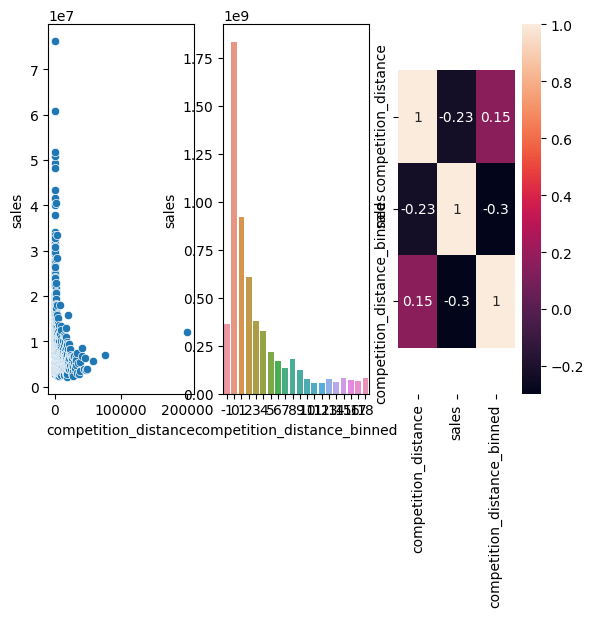

In [78]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1 , 3 , 1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1); #concentração dos dados

plt.subplot( 1 , 3 , 2)
bins= list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins).cat.codes
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned' , y='sales' , data=aux2);

plt.subplot( 1 , 3 , 3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

In [53]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
298,3900.0,4006273,"(3000, 4000]"
253,3160.0,4365642,"(3000, 4000]"
151,1700.0,18930319,"(1000, 2000]"
181,2070.0,7328111,"(2000, 3000]"


### **H3.** Lojas com competidores a mais tempo deveriam vendem mais.
**FALSA**. Lojas com competidores a mais tempo vendem menos.

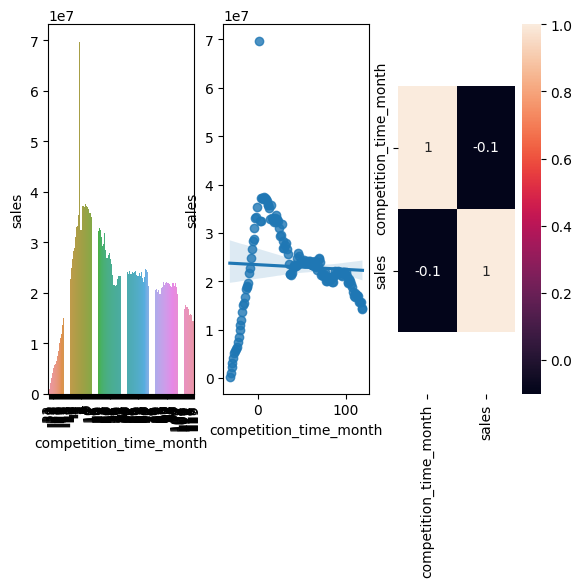

In [84]:
plt.subplot( 1 , 3 , 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation = 90);

plt.subplot( 1 , 3 , 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2);

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

## 4.3. Analise multivariada